## Obtain Anual Weather Types (AWT) following the methodoly explained in Anderson et al. (2019)

inputs required: 
  * Averaged monthly Sea Surface Temperature (SST) anomalies. Extracted from the Extended Reconstructed 
  * Sea Surface Temperature v4 (ERSSTv4; Huang et al., (2015)). Rectangular region from 120°E to 280°E and 5°N to 5°S 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import pickle
from datetime import datetime

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.pca import PCA_LatitudeAverage
from teslakit.kma import KMA_simple
from teslakit.statistical import CopulaSimulation
from teslakit.alr import ALR_WRP

from teslakit.plotting.awt import Plot_AWTs_EOFs, Plot_AWTs, Plot_AWTs_Dates, Plot_AWTs_Validation
from teslakit.plotting.pcs import Plot_PCs_Compare_3D, Plot_PCs_WT



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

SST = db.Load_SST()  # SST Predictor
var_name = 'SST'
print(SST.SST)

# SST Predictor PCA parameters
pca_year_ini = 1880
pca_year_end = 2016
pca_month_ini = 6
pca_month_end = 5
num_clusters = 6
repres = 0.95

# ALR parameters
alr_markov_order = 2

# Simulation
num_PCs_rnd = 1000
num_sims = 3
y1_sim = 1700
y2_sim = 2700


<xarray.DataArray 'SST' (longitude: 81, latitude: 5, time: 1961)>
[794205 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 4.0 2.0 0.0 -2.0 -4.0
  * longitude  (longitude) float32 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2017-05-01
Attributes:
    units:       celsius degrees
    short_name:  sst
    long_name:   sea surface temperature



## SST  - Principal Components Analysis

In [4]:
# --------------------------------------
# Principal Components Analysis SST data

# PCA (anomalies, latitude average)
SST_PCA = PCA_LatitudeAverage(SST, var_name, pca_year_ini, pca_year_end, pca_month_ini, pca_month_end);
print(SST_PCA)

# store SST PCs
db.Save_SST_PCA(SST_PCA)


<xarray.Dataset>
Dimensions:        (n_components: 137, n_features: 972, n_lon: 81)
Dimensions without coordinates: n_components, n_features, n_lon
Data variables:
    PCs            (n_components, n_components) float64 7.972 ... 9.567e-15
    EOFs           (n_components, n_features) float64 -0.006245 ... -0.003501
    variance       (n_components) float64 467.5 99.72 ... 4.251e-05 9.22e-29
    var_anom_std   (n_features) float64 0.182 0.1846 0.2079 ... 0.9462 0.908
    var_anom_mean  (n_features) float64 0.004979 0.00597 ... 0.008235 0.008039
    time           (n_components) datetime64[ns] 1880-06-01 ... 2016-06-01
    pred_lon       (n_lon) float32 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
Attributes:
    method:   anomalies, latitude averaged


In [5]:
# PCA data for plots

lon  = SST_PCA.pred_lon.values[:]
PCs  = SST_PCA.PCs.values[:]
EOFs = SST_PCA.EOFs.values[:]
vari = SST_PCA.variance.values[:]
time = SST_PCA.time.values[:]


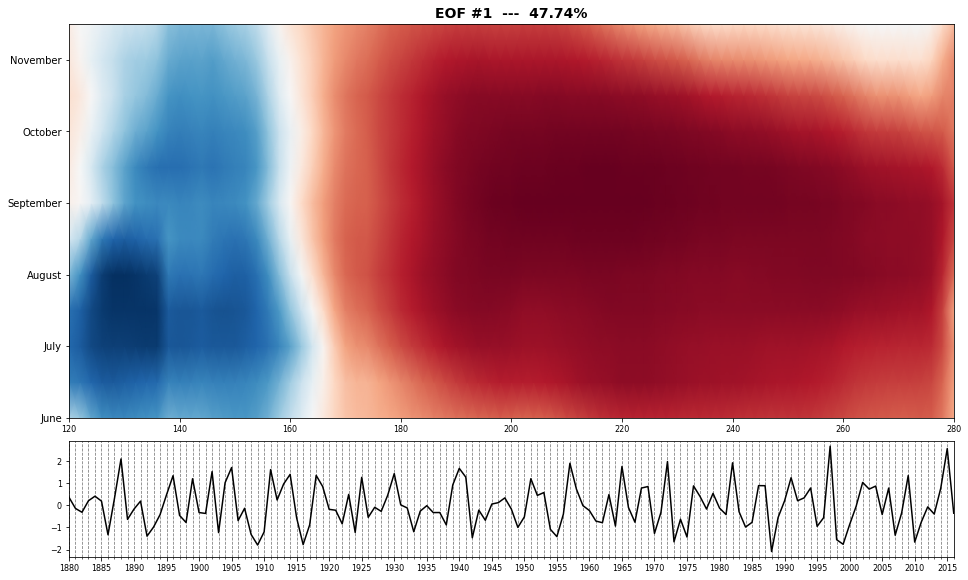

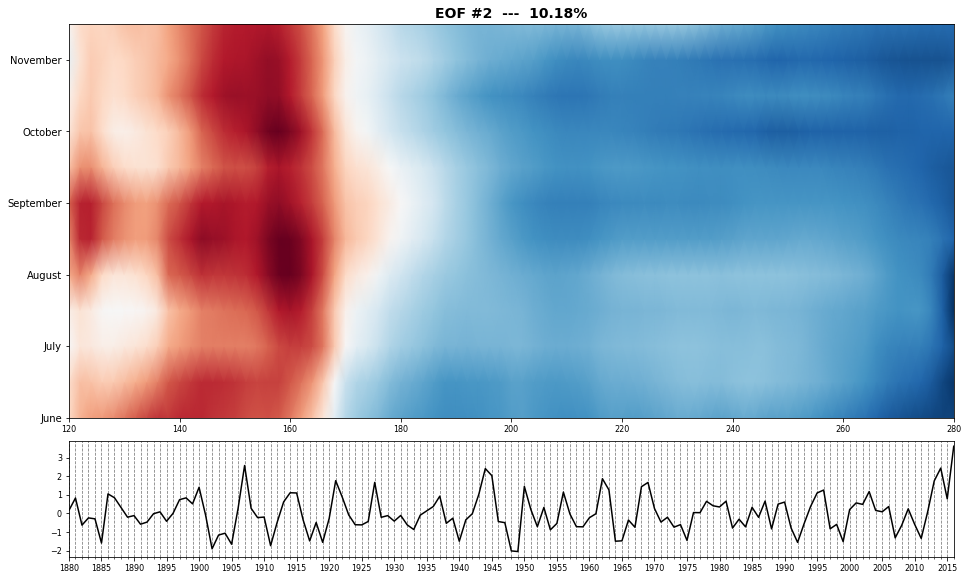

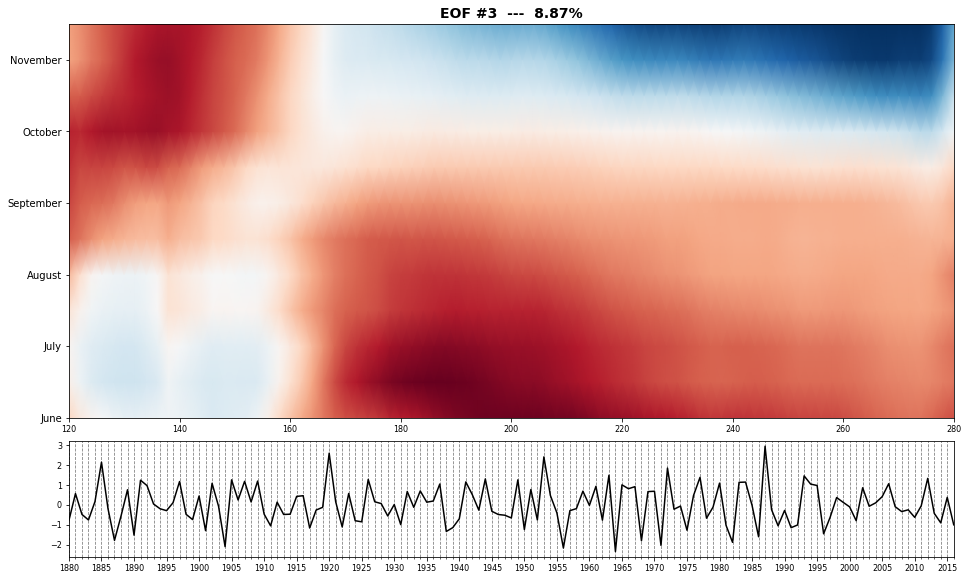

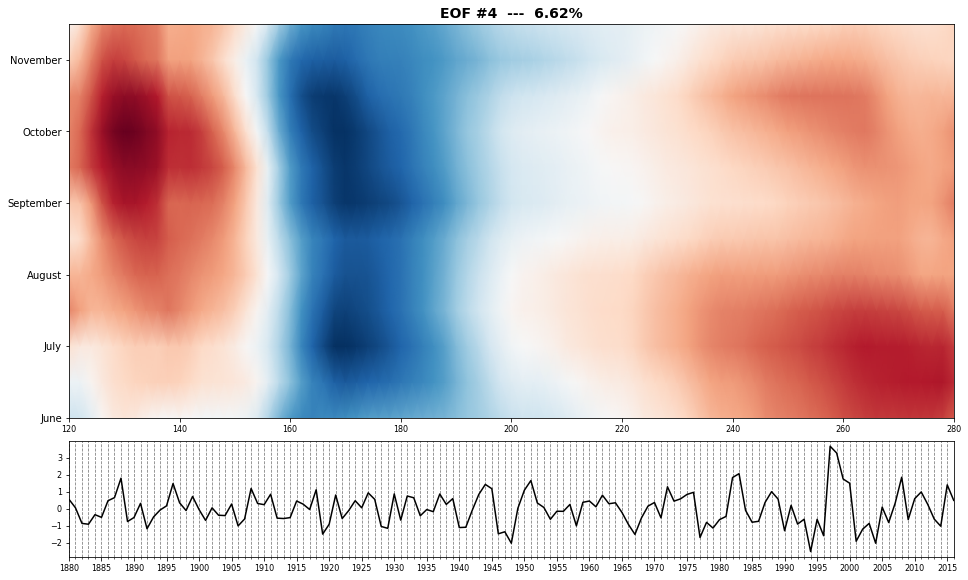

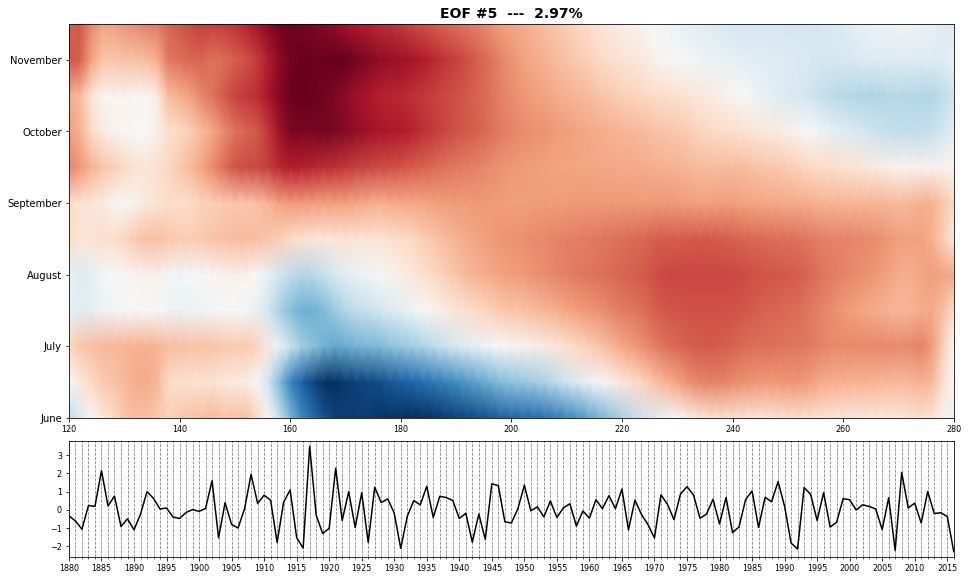

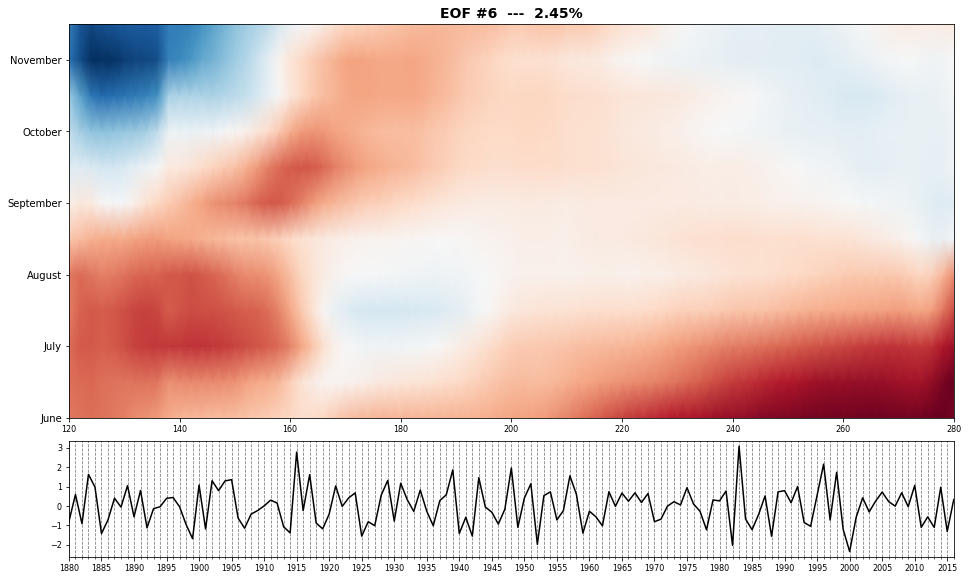

In [6]:
# plot first 6 EOFs 

Plot_AWTs_EOFs(PCs, EOFs, vari, time, lon, 6);



## SST - KMeans Classification --> Annual Weather Types

In [7]:
# --------------------------------------
# KMA Classification 

SST_AWTs = KMA_simple(SST_PCA, num_clusters, repres)
print(SST_AWTs)

# store SST AWTs
db.Save_SST_KMA(SST_AWTs)


<xarray.Dataset>
Dimensions:     (n_clusters: 6, n_features: 28, n_pcacomp: 137, n_pcafeat: 972)
Dimensions without coordinates: n_clusters, n_features, n_pcacomp, n_pcafeat
Data variables:
    bmus        (n_pcacomp) int64 2 4 2 2 2 4 5 2 0 4 2 ... 5 4 1 5 5 4 3 1 0 3
    cenEOFs     (n_clusters, n_features) float64 36.66 -5.82 ... -0.2609 0.2004
    centroids   (n_clusters, n_pcafeat) float64 -0.4368 -0.5717 ... -0.2842
    Km          (n_clusters, n_pcafeat) float64 -0.07452 -0.09959 ... -0.25
    group_size  (n_clusters) int64 18 18 26 20 27 28
    PCs         (n_pcacomp, n_features) float64 7.972 1.668 ... -0.3103 -0.06965
    variance    (n_pcacomp) float64 467.5 99.72 86.87 ... 4.251e-05 9.22e-29
    time        (n_pcacomp) datetime64[ns] 1880-06-01 1881-06-01 ... 2016-06-01


In [8]:
# KMA data for plots
bmus = SST_AWTs.bmus.values[:]
time = SST_AWTs.time.values[:]
Km   = SST_AWTs.Km.values[:]


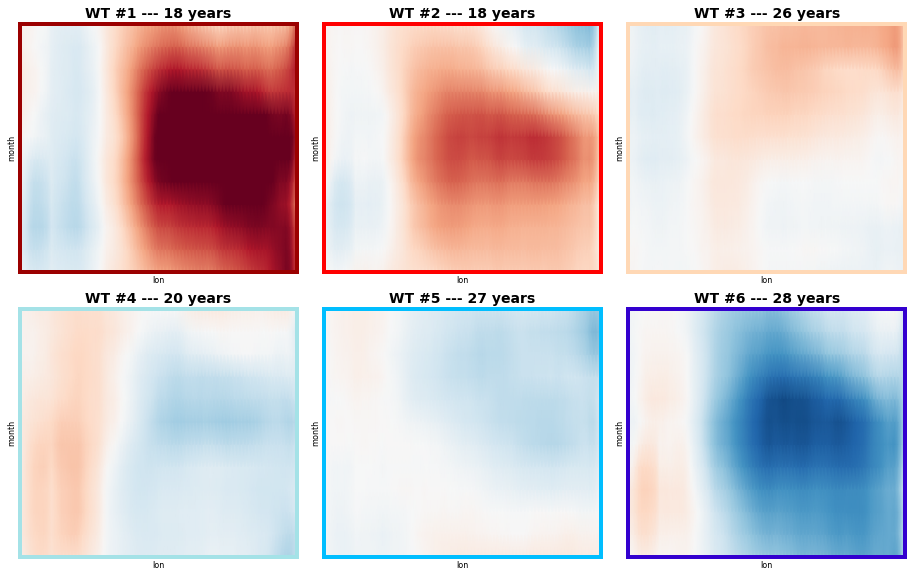

In [9]:
# Plot Annual Weather Types
Plot_AWTs(bmus, Km, num_clusters, lon);


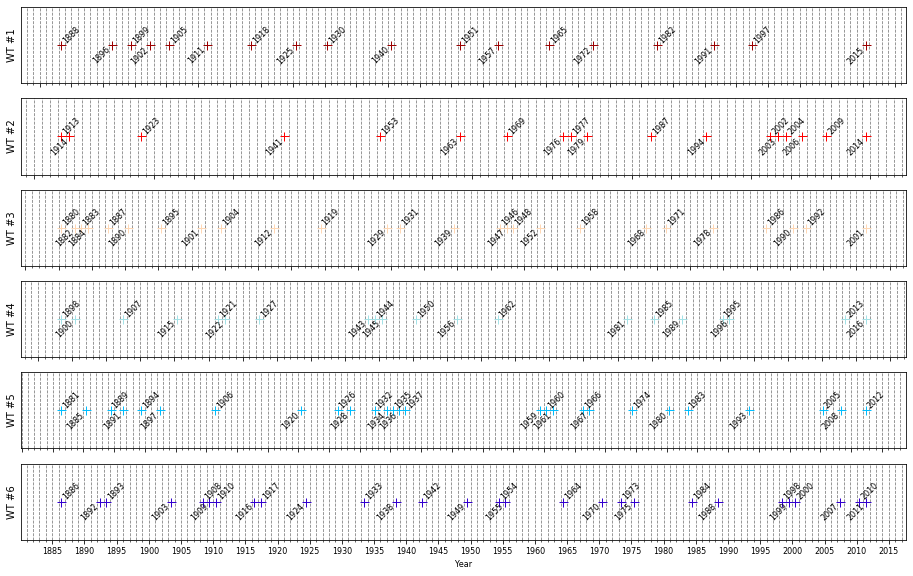

In [10]:
# Plot year/label AWTs
Plot_AWTs_Dates(bmus, time, num_clusters);


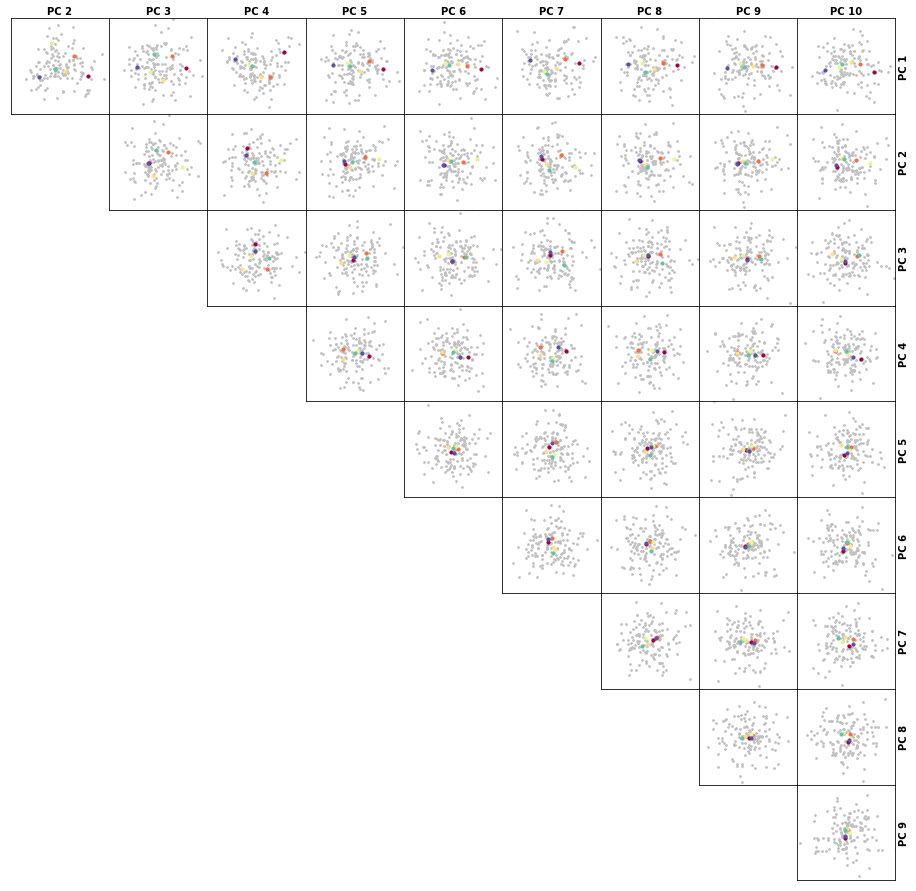

In [11]:
# Plot PCs with AWTs centroids
Plot_PCs_WT(PCs, vari, bmus, num_clusters, n=10);


In [12]:
# --------------------------------------
# PCs123 random generation with Copulas

bmus = SST_AWTs.bmus.values[:]
PCs  = SST_AWTs.PCs.values[:]
vari = SST_AWTs.variance.values[:]

# copula simulation kernels
kernels = ['KDE', 'KDE', 'KDE']

# first 3 PCs
PC1 = np.divide(PCs[:,0], np.sqrt(vari[0]))
PC2 = np.divide(PCs[:,1], np.sqrt(vari[1]))
PC3 = np.divide(PCs[:,2], np.sqrt(vari[2]))

# for each AWT: generate copulas and simulate data
PCs_fit = {}
PCs_rnd = {}
for ic in range(num_clusters):

    # find all the best match units 
    ind = np.where(bmus == ic)[:]

    # PCs for weather type
    PC123 = np.column_stack((PC1[ind], PC2[ind], PC3[ind]))

    # statistical simulate PCs using copulas with KDE (kernel density estimation)
    PC123_rnd = CopulaSimulation(PC123, kernels, num_PCs_rnd)

    # store data at dictionaries
    PCs_fit['{0}'.format(ic+1)] = PC123
    PCs_rnd['{0}'.format(ic+1)] = PC123_rnd
    
# store PCs used for fitting and simulated
db.Save_SST_PCs_fit_rnd(PCs_fit, PCs_rnd)


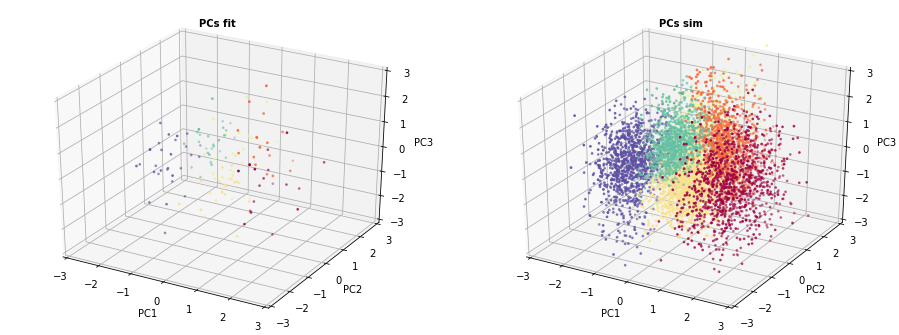

In [13]:
# Plot Weather Type 3D PCs for fit and random generation data
Plot_PCs_Compare_3D(PCs_fit, PCs_rnd);


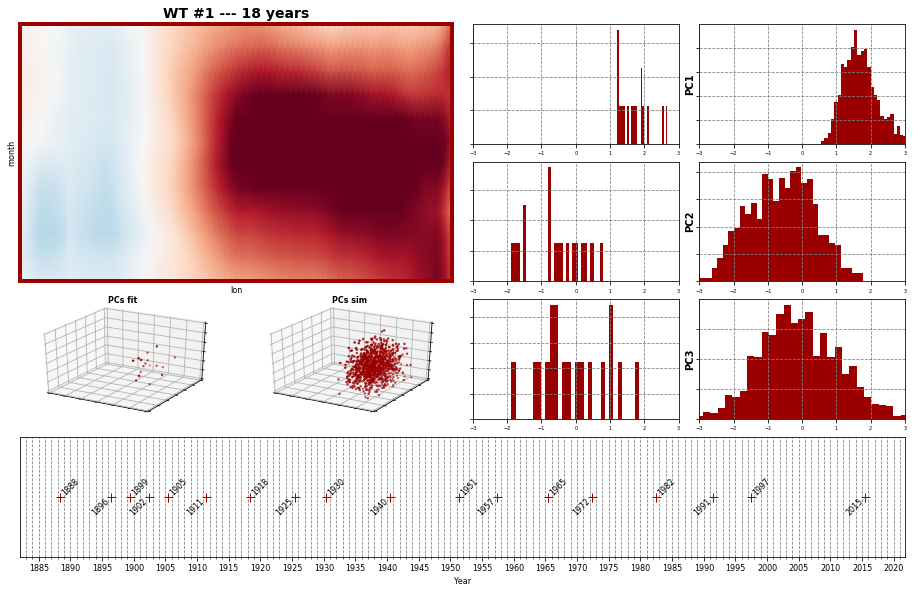

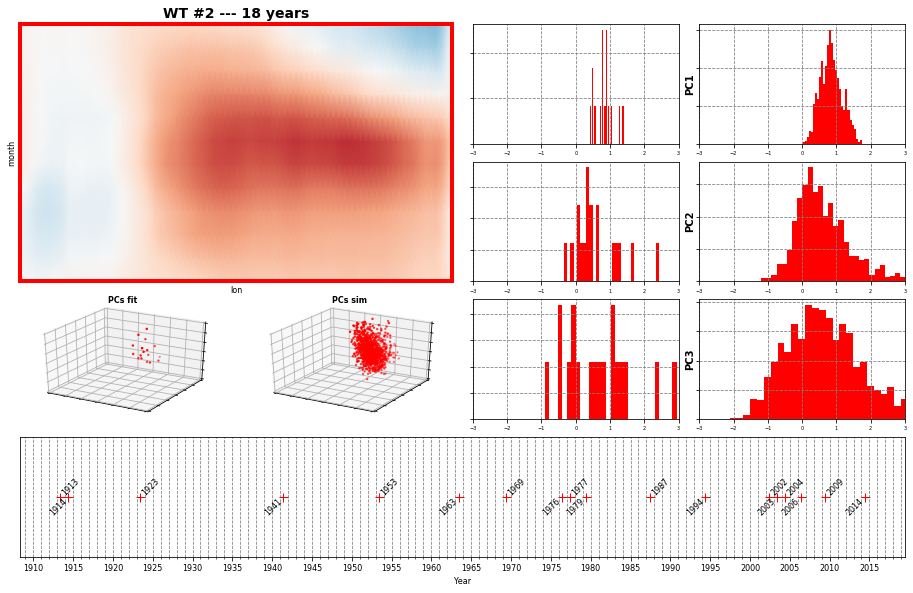

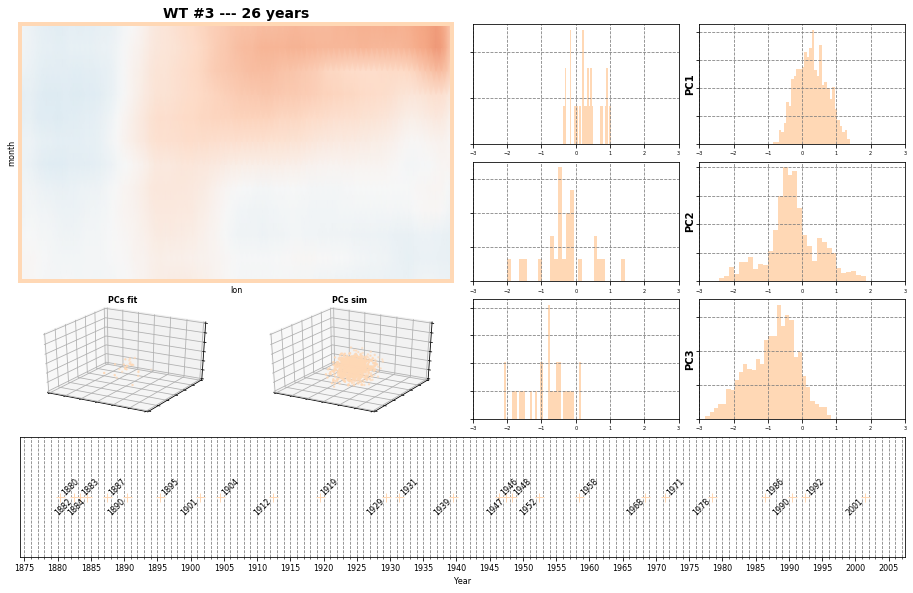

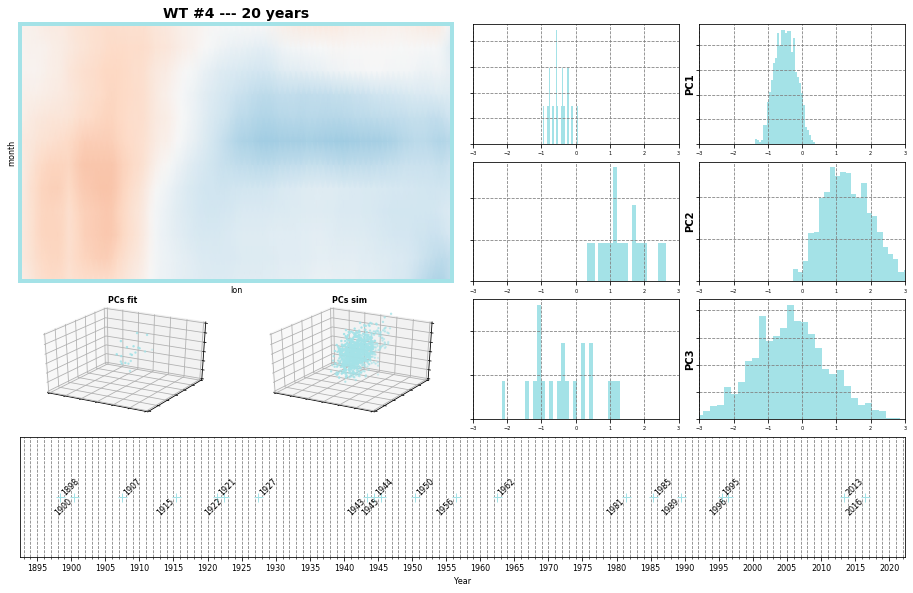

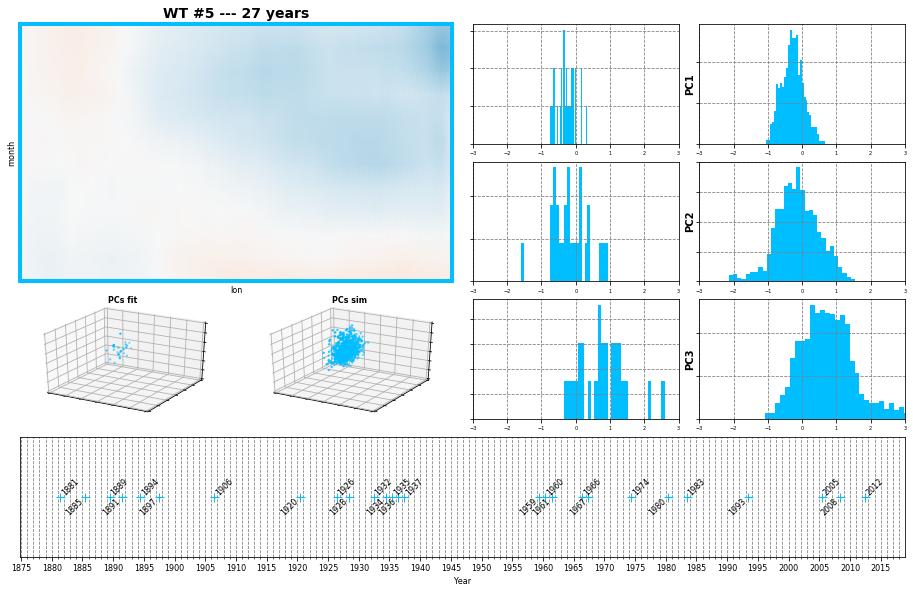

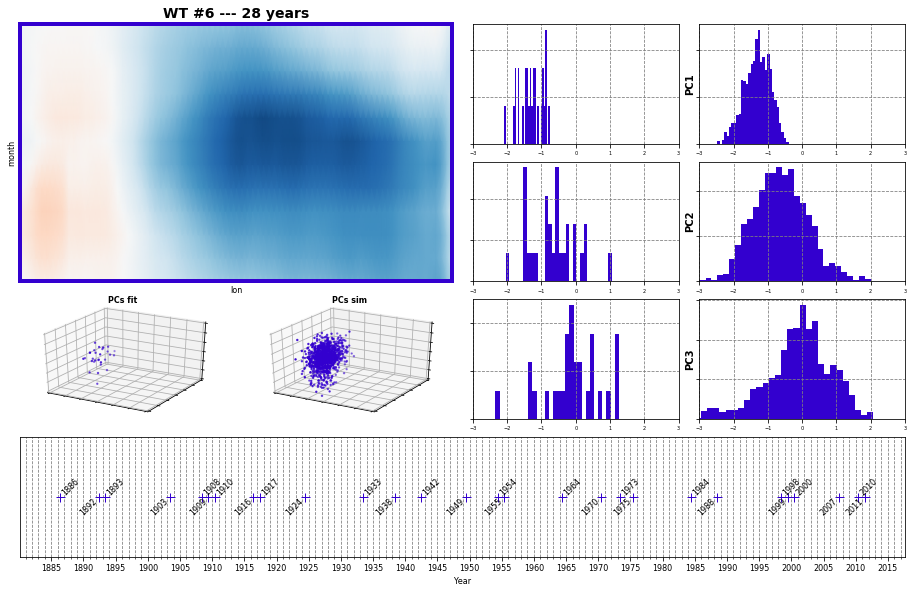

In [14]:
# Plot Annual Weather Types validation reports
Plot_AWTs_Validation(bmus, time, Km, num_clusters, lon, PCs_fit, PCs_rnd);



## Autoregressive Logistic Regression

In [15]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

# bmus series
bmus_fit = xr.Dataset(
    {
        'bmus':(('time',), SST_AWTs.bmus.values[:] + 1),
    },
    coords = {'time': SST_AWTs.time.values[:]}
)

# ALR terms
d_terms_settings = {
    'mk_order'  : 2,
    'constant' : True,
    'long_term' : False,
    'seasonality': (False, []),
}

# ALR wrapper
ALRW = ALR_WRP(db.paths.site.SST.alrw)
ALRW.SetFitData(num_clusters, bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=50000)



Fitting autoregressive logistic model ...
Optimization done in 0.14 seconds



In [20]:
# show fit report
#ALRW.Report_Fit(summary=True)


In [17]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# simulation dates (annual array)
dates_sim = [datetime(y, pca_month_ini,1) for y in range(y1_sim-1, y2_sim+1)]

# launch simulation
ALR_sim = ALRW.Simulate(num_sims, dates_sim)

# store simulated Annual Weather Types
SST_AWTs_sim = ALR_sim.evbmus_sims.to_dataset()
print(SST_AWTs_sim)

db.Save_SST_AWT_sim(SST_AWTs_sim)


ALR model fit   : 1880-06-01 --- 2016-06-01
ALR model sim   : 1699-06-01 --- 2700-06-01

Launching 3 simulations...

Sim. Num. 003: 100%|██████████| 1000/1000 [00:00<00:00, 2994.35it/s]

<xarray.Dataset>
Dimensions:      (n_sim: 3, time: 1002)
Coordinates:
  * time         (time) object 1699-06-01 1700-06-01 ... 2699-06-01 2700-06-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 5 5 5 3 3 3 5 5 5 4 ... 5 5 5 6 3 2 5 2 4 3


In [18]:
# --------------------------------------
# PCs generation

# solve each ALR simulation
l_PCs_sim = []
for s in SST_AWTs_sim.n_sim:

    evbmus_sim = SST_AWTs_sim.sel(n_sim=s).evbmus_sims.values[:]

    # generate random PCs
    pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
    for c, m in enumerate(evbmus_sim):
        options = PCs_rnd['{0}'.format(int(m))]
        r = np.random.randint(options.shape[0])
        pcs123_sim[c,:] = options[r,:]
        
    # denormalize simulated PCs
    PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(vari[0]))
    PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(vari[1]))
    PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(vari[2]))

    # append simulated PCs
    l_PCs_sim.append(
        xr.Dataset(
            {
                'PC1'  : (('time',), PC1_sim),
                'PC2'  : (('time',), PC2_sim),
                'PC3'  : (('time',), PC3_sim),
                'evbmus_sim' : (('time',), evbmus_sim),
            },
            {'time' : dates_sim}
        )
    )

# concatenate simulations
SST_PCs_sim = xr.concat(l_PCs_sim, 'n_sim')
print(SST_PCs_sim)

# store simulated PCs
db.Save_SST_PCs_sim(SST_PCs_sim)


<xarray.Dataset>
Dimensions:     (n_sim: 3, time: 1002)
Coordinates:
  * time        (time) object 1699-06-01 1700-06-01 ... 2699-06-01 2700-06-01
Dimensions without coordinates: n_sim
Data variables:
    PC1         (n_sim, time) float64 -4.706 16.93 -14.02 ... -0.4747 -0.1555
    PC2         (n_sim, time) float64 -5.492 -15.74 3.881 ... -1.654 0.934
    PC3         (n_sim, time) float64 18.94 -5.108 6.256 ... 10.68 -3.326
    evbmus_sim  (n_sim, time) int64 5 3 5 4 4 1 5 2 6 5 ... 3 5 6 3 1 3 5 6 5 3


PerpetualYear bmus comparison skipped.
timedelta (days): Hist - 365, Sim - 365)


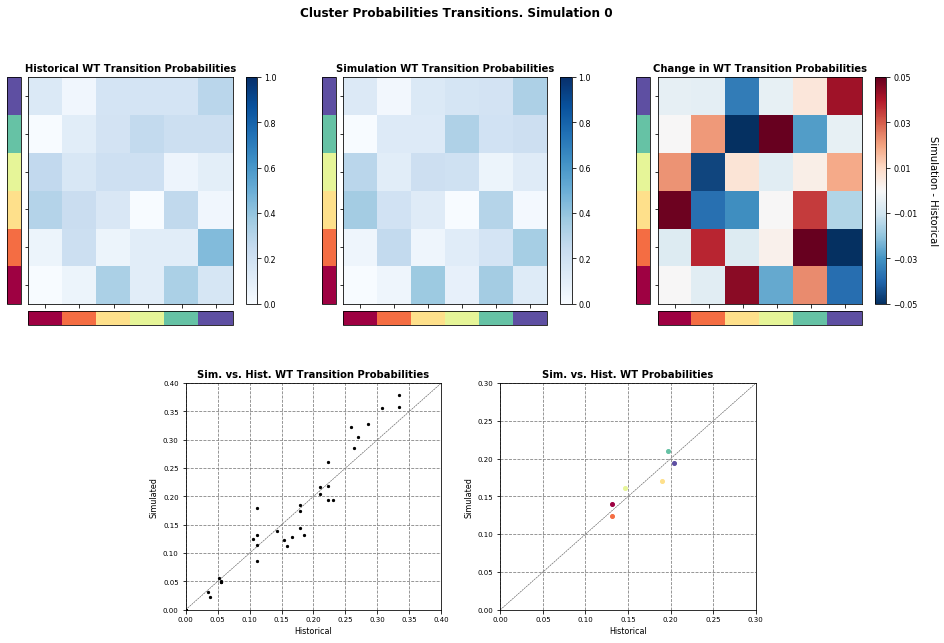

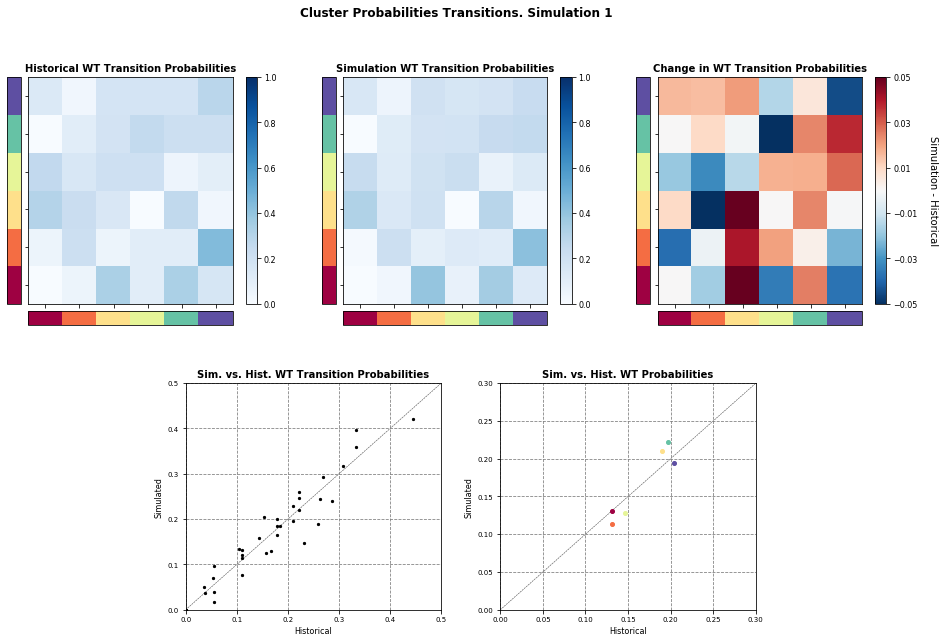

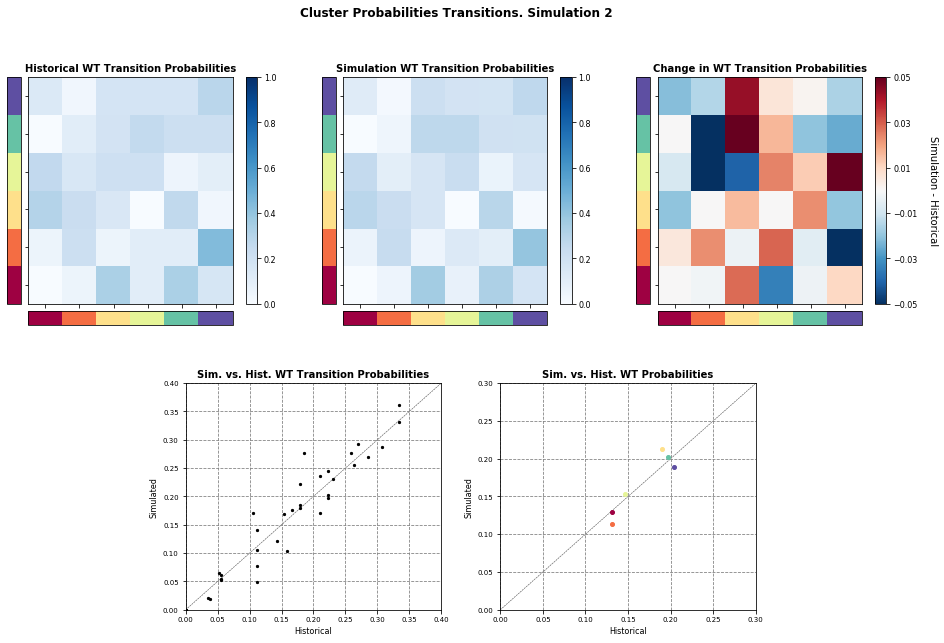

In [19]:
# show simulation report
ALRW.Report_Sim()


In [ ]:
# TODO: ALR_ReportSim, add Persistences fig